In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import glob
from pathlib import Path

from filter.RaymondFilters import RaymondFilter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from plot_tools import *

# Local import 

from spectra.py_spectra import *

# High Pass values for various values of dx - because of high pass, we want the lowpass filter cutoff to have
# a large (R~0.9) value

npass = 6

dx    = 8

klevels = [25]

filtered_W_name = "W_%2.2i" % dx

# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def read_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

def save_mfdataset_list(ds, dir, gridType=None):
    """
    Use xarray.save_mfdataset to save multiple netcdf files from a list, using the original file strings as a pattern
    """

    # Use new pathlib for Python > 3.5
    Path(dir).mkdir(parents=True, exist_ok=True)

    for n, hour in enumerate(ds.fhour):
        fcstHour  = ds.isel(fhour=n).fhour.values
        fcstStart = ds.isel(fhour=n).fcstStart
        date      = ds.isel(fhour=n).date      
        
        if gridType == None:
            gridType = ds.isel(fhour=n).attrs['gridType']
            
        outfilename = os.path.join(dir, '%s_%08d%02d_F%02d.nc' % (gridType, date, fcstStart, fcstHour))
        
        ds.isel(fhour=n).to_netcdf(outfilename, mode='w')  
        print(f'Successfully wrote new data to file:: {outfilename}','\n')
    
    return


In [2]:
# Open data sets

def filter_ds(dir, output_dir, suffix, dx = 10, npass = 6, writeout=False):
    
    new_dir = "%s_%s" % (output_dir, suffix)
    
    ds  = read_mfdataset_list(dir , "econus_*.nc")
    
    print(ds['W'])

    # Set up cartopy stuff here, so the plot routine is already set to use it.

    fig, axes = init_cartopy_plot(ncols=2, nrows=1, figsize=(20,10))

    # Plot the initial data

    cb_info = plot_w_from_xarray(ds, fhour=4, title='UNFILTERED', ax = axes[0])

    # Convert to numpy arrays, fill in zeros

    w = np.nan_to_num(ds.W.values).astype('float64')

    nhour, nz, ny, nx = w.shape
    
    w_filtered = np.zeros_like(w)

    for n in np.arange(nhour):
        
        print("File %d being processed" % n)

        w_filtered[n] = RaymondFilter(w[n], dx, klevels=klevels, order=6, npass = npass, fortran = False, highpass=True)
    
    ds['W'] = xr.DataArray(w_filtered, dims = ['fhour','nz','ny','nx'])
    
    print(ds['W'])

    # Plot the Filtered data

    cb_info = plot_w_from_xarray(ds, fhour=4, title='FILTERED', ax = axes[1])

    if writeout:
        save_mfdataset_list(ds, new_dir, gridType='filtered')
    
    return

In [7]:
input_config =  {
              "filtered_filename": "",
              "filter_dx":          12,
              "filter_npass":       1,
              "input_dir":   "/work/larissa.reames",
              "output_dir":  "/work/wicker/CAM_case_studies",
              "cases": {
                        "2020030212": ["ctrl"],
                        #"2020030212": ["hrrr", "ctrl", "nord3", "nam"],
                        # "2021052612": ["hrrr", "ctrl", "nord3"],
                       },
               "zoom": {
                        "2019071918": [44.0, 49.0,  -92.0, -87.0, 5],
                        "2020081006": [39.0, 44.0,  -92.0, -86.0, 5],
                        "2020030212": [34.0, 39.5,  -92.0, -85.0, 2],
                        "2021090100": [35.5, 43.0,  -80.0, -73.0, 5],
                        "2020050300": [35.0, 40.0,  -92.0, -85.0, 5],
                        "2020070700": [42.0, 46.0, -101.0, -96.0, 5],
                        "2021052612": [33.5, 43.0, -102.5, -97.0, 5],
                        # "2021052612": [37.0, 40.5, -100., -97.5, 5]
                        }
                   }


====> Begin processing runs

-------> Parameter Filter SCALE: 12 

-------> Parameter        NPASS: 1 

-------> Parameter FILTERED FILE DIRECTORY: W_12 


----> Processing run: ctrl for day:  2020030212 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunksize=(45,), meta=np.ndarray>
    lons       (ny, nx) float32 dask.array<chunksize=(959, 1128), meta=np.ndarray>
    lats       (ny, nx) float32 dask.array<chunksize=(959, 1128), meta=np.ndarray>
  * fhour      (fhour) int64 12 13 14 15 16 17
    init_time  int64 202003021200
Dimensions without coordinates: nz, ny, nx

Plot Lat Min: 22.9  Lat Max:  51.6  

Plot Lon Min: -108.2  Lon Max:  -62.4



/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


File 0 being processed
RaymondFilter6:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6:  NPASS:  1 

RaymondFilter6: KLEVELS arg supplied, only filtering levels: [25] 

Y-Parallel Loop took 0.3899 seconds

X-Parallel Loop took 0.3476 seconds

Loop for 3D array took 1.0749 seconds

File 1 being processed
RaymondFilter6:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6:  NPASS:  1 

RaymondFilter6: KLEVELS arg supplied, only filtering levels: [25] 

Y-Parallel Loop took 0.3723 seconds

X-Parallel Loop took 0.3451 seconds

Loop for 3D array took 1.0519 seconds

File 2 being processed
RaymondFilter6:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6:  NPASS:  1 

RaymondFilter6: KLEVELS arg supplied, only filtering levels: [25] 

Y-Parallel Loop took 0.3485 seconds

X-Parallel Loop took 0.3434 seconds

Loop for 3D array took 1.0338 seconds

File 3 being processed
RaymondFilter6:  Inp

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



====> Ended processing runs



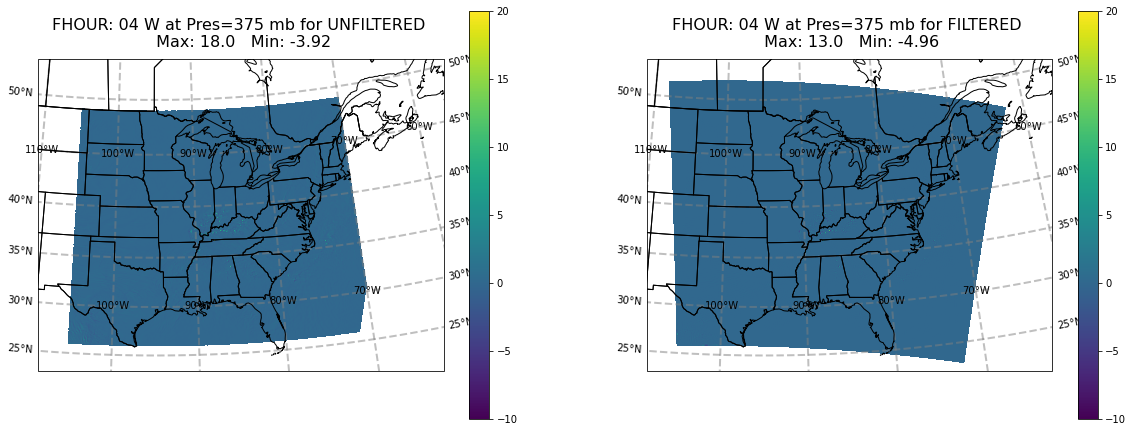

In [8]:
# Input data sets....

#from input_default import input_single as input_config

input_dir  = input_config["input_dir"]
output_dir = input_config["output_dir"]

filtered_filename = input_config["filtered_filename"]
filter_dx         = input_config["filter_dx"]
filter_npass      = input_config["filter_npass"]

if len(filtered_filename) == 0:
    filtered_filename = "W_%2.2i" % filter_dx
    
#------------------------------------------------------------------------------------
# cut and past from below here
#

print("\n====> Begin processing runs\n")

print("-------> Parameter Filter SCALE: %d \n" % filter_dx)
print("-------> Parameter        NPASS: %d \n" % filter_npass)
print("-------> Parameter FILTERED FILE DIRECTORY: %s \n" % filtered_filename)

for day in input_config["cases"]:
    for run in input_config["cases"][day]:
        
        print("\n----> Processing run: %s for day:  %s \n" % (run,day))
        run_dir = str(os.path.join(input_dir, day, run))
        out_dir = str(os.path.join(output_dir, day, run))
        filter_ds(run_dir, out_dir, filtered_filename, dx=filter_dx, npass=filter_npass, writeout=False)
        
print("\n====> Ended processing runs\n")

del(input_config)


In [ ]:
import json

with open("sample.json", "w") as outfile:
    json.dump(input_spec, outfile)
    
import yaml
with open("sample.yaml", "w") as outfile:
    yaml.dump(input_spec, outfile)

In [141]:
with open("sample.yaml", "r") as outfile:
    d = yaml.load(outfile, Loader=yaml.FullLoader)
    
print(d)

{'cases': {'2019071918': ['hrrr', 'ctrl', 'nord3'], '2020081006': ['hrrr', 'ctrl', 'nord3']}, 'input_dir': '/Users/Louis.Wicker/CAM_Case_Studies', 'output_dir': '/Users/Louis.Wicker/CAM_Case_Studies'}


In [134]:
yaml.load?

Signature: yaml.load(stream, Loader)
Docstring:
Parse the first YAML document in a stream
and produce the corresponding Python object.
File:      ~/miniconda3/envs/mypip/lib/python3.9/site-packages/yaml/__init__.py
Type:      function


In [142]:
f = ""
print(len(f))

0


In [78]:
from scipy.sparse.linalg import dsolve

In [79]:
help(dsolve)

Help on package scipy.sparse.linalg.dsolve in scipy.sparse.linalg:

NAME
    scipy.sparse.linalg.dsolve

DESCRIPTION
    Linear Solvers
    
    The default solver is SuperLU (included in the scipy distribution),
    which can solve real or complex linear systems in both single and
    double precisions.  It is automatically replaced by UMFPACK, if
    available.  Note that UMFPACK works in double precision only, so
    switch it off by::
    
        >>> use_solver(useUmfpack=False)
    
    to solve in the single precision. See also use_solver documentation.
    
    Example session::
    
        >>> from scipy.sparse import csc_matrix, spdiags
        >>> from numpy import array
        >>> from scipy.sparse.linalg import spsolve, use_solver
        >>>
        >>> print("Inverting a sparse linear system:")
        >>> print("The sparse matrix (constructed from diagonals):")
        >>> a = spdiags([[1, 2, 3, 4, 5], [6, 5, 8, 9, 10]], [0, 1], 5, 5)
        >>> b = array([1, 2, 3, 4

In [89]:
from scipy.sparse.linalg import linsolve

In [90]:
linsolve.*?

linsolve.LinAlgError
linsolve.MatrixRankWarning
linsolve.SparseEfficiencyWarning
linsolve.__all__
linsolve.__builtins__
linsolve.__cached__
linsolve.__class__
linsolve.__delattr__
linsolve.__dict__
linsolve.__dir__
linsolve.__doc__
linsolve.__eq__
linsolve.__file__
linsolve.__format__
linsolve.__ge__
linsolve.__getattribute__
linsolve.__gt__
linsolve.__hash__
linsolve.__init__
linsolve.__init_subclass__
linsolve.__le__
linsolve.__loader__
linsolve.__lt__
linsolve.__name__
linsolve.__ne__
linsolve.__new__
linsolve.__package__
linsolve.__reduce__
linsolve.__reduce_ex__
linsolve.__repr__
linsolve.__setattr__
linsolve.__sizeof__
linsolve.__spec__
linsolve.__str__
linsolve.__subclasshook__
linsolve.asarray
linsolve.copy
linsolve.csc_matrix
linsolve.csr_matrix
linsolve.factorized
linsolve.is_pydata_spmatrix
linsolve.isspmatrix
linsolve.isspmatrix_csc
linsolve.isspmatrix_csr
linsolve.noScikit
linsolve.np
linsolve.spilu
linsolve.splu
linsolve.spsolve
linsolve.spsolve_triangular
linsolve.umfpac

In [92]:
linsolve.spsolve?

Signature: linsolve.spsolve(A, b, permc_spec=None, use_umfpack=True)
Docstring:
Solve the sparse linear system Ax=b, where b may be a vector or a matrix.

Parameters
----------
A : ndarray or sparse matrix
    The square matrix A will be converted into CSC or CSR form
b : ndarray or sparse matrix
    The matrix or vector representing the right hand side of the equation.
    If a vector, b.shape must be (n,) or (n, 1).
permc_spec : str, optional
    How to permute the columns of the matrix for sparsity preservation.
    (default: 'COLAMD')

    - ``NATURAL``: natural ordering.
    - ``MMD_ATA``: minimum degree ordering on the structure of A^T A.
    - ``MMD_AT_PLUS_A``: minimum degree ordering on the structure of A^T+A.
    - ``COLAMD``: approximate minimum degree column ordering
use_umfpack : bool, optional
    if True (default) then use umfpack for the solution.  This is
    only referenced if b is a vector and ``scikit-umfpack`` is installed.

Returns
-------
x : ndarray or sparse ma

In [99]:
linsolve.use_solver(assumeSortedIndices=True, useUmfpack=True)